In [1]:
import numpy as np
from matplotlib import pyplot as plt

from scipy import stats as sps

In [2]:
def GetBrownianMotion(tn, Npaths):
    n = len(tn)
    
    W = np.zeros((n, Npaths))
    eps = np.random.randn(n-1, Npaths)
    
    W[1:, :] = np.cumsum(eps, axis=0) * np.sqrt(np.diff(tn).reshape(-1, 1))
    return W


def GetAlpha(tn, Npaths, alpha0, nu):
    W = GetBrownianMotion(tn, Npaths)
    return alpha0 * np.exp( -0.5 * nu**2 * tn.reshape(-1, 1) + nu * W)


def genAntipath(Npaths):
    eps = np.random.randn(Npaths // 2)
    eps = np.r_[eps, -eps]
    if Npaths % 2:
        eps = np.r_[eps, np.random.randn(1)]
    return eps

In [3]:
def SimulateSABRBessel1(tn, Npaths, alpha0, nu, F0, beta, rho):
    X = F0 ** (-beta + 1) * np.ones((Npaths, ))
    
    y = np.log(alpha0) * np.ones((Npaths, ))
    
    for t in range(1, len(tn)):
        
        dt = tn[t] - tn[t - 1]
        
        dZ = genAntipath(Npaths) * np.sqrt(dt)
        dY = genAntipath(Npaths) * np.sqrt(dt)
        dW = rho * dZ + np.sqrt(1 - rho ** 2) * dY
     
        b = -(X + (-beta + 1) * np.exp(y) * dW)
        c = -np.exp(2 * y) * beta * (beta - 1) / 2 * dt
        D = b ** 2 - 4 * c
        D = np.maximum(D, 0.0)
        X = 0.5 * (-b + np.sqrt(D))
        X = np.maximum(X, 0.0)
        
        y += -0.5 * nu ** 2 * dt + nu * dZ
        
    F = (X) ** (1 / (-beta + 1))
    return F

In [4]:
def SimulateSABRLog(tn, Npaths, alpha0, nu, F0, beta, rho):
    
    X = (beta - 1) * np.log(F0) * np.ones((Npaths, ))
    
    y = np.log(alpha0) * np.ones((Npaths, ))
    
    for t in range(1, len(tn)):
        
        dt = tn[t] - tn[t - 1]
        
        dZ = genAntipath(Npaths) * np.sqrt(dt)
        dY = genAntipath(Npaths) * np.sqrt(dt)
        dW = rho * dZ + np.sqrt(1 - rho ** 2) * dY
        
        
        
        X += -0.5 * (beta - 1) * np.exp(2 * (X + y) ) * dt + (beta - 1) * np.exp(X + y) * dW 
        
        y += -0.5 * nu ** 2 * dt + nu * dZ
    F = np.exp(X / (beta - 1))
    return F


def SimulateSABREuler(tn, Npaths, alpha0, nu, F0, beta, rho):
    F = F0 * np.ones((Npaths, ))
    
    y = np.log(alpha0) * np.ones((Npaths, ))
    
    for t in range(1, len(tn)):
        
        dt = tn[t] - tn[t - 1]
        
        dZ = genAntipath(Npaths) * np.sqrt(dt)
        dY = genAntipath(Npaths) * np.sqrt(dt)
        dW = rho * dZ + np.sqrt(1 - rho ** 2) * dY

        F += dW * np.exp(y) * (F ** beta)
        F = np.maximum(F, 0.0)
        
        y += -0.5 * (nu ** 2) * dt + nu * dZ
    return F


def SimulateSABREulerModified(tn, Npaths, alpha0, nu, F0, beta, rho):
    F = F0 * np.ones((Npaths, ))
    
    y = np.log(alpha0) * np.ones((Npaths, ))
    
    for t in range(1, len(tn)):
        
        dt = tn[t] - tn[t - 1]
        
        dZ = genAntipath(Npaths) * np.sqrt(dt)
        dY = genAntipath(Npaths) * np.sqrt(dt)
        dW = rho * dZ + np.sqrt(1 - rho ** 2) * dY

        F += dW * np.exp(y) * (F ** beta) + 0.5 * beta * np.exp(2 * y) * F ** (2 * beta - 1) * (dW ** 2 - dt)
        y += -0.5 * (nu ** 2) * dt + nu * dZ
        
        F = np.maximum(F, 0.0)
    return F

In [73]:
def IntegralVarSampling(Npaths, alp0, nu, dt):
    W = genAntipath(Npaths) * np.sqrt(dt)
    alpha = alp0 * np.exp( nu * W - 0.5 * nu ** 2 * dt)
    
    m = (alp0 ** 2) * dt * ( 1 + nu * W + (1.0/3.0) * (nu ** 2) * (2 * W**2 - dt / 2) * \
                           (1.0/3.0) * (nu ** 3) * (W**3 - W * dt) + \
                           (1.0/5.0) * (nu ** 4) * ((2.0/3.0) * W ** 4 - (3.0/2.0) * W**2 * dt + 2 * dt ** 2) )
    v = (1.0/3.0) * (alp0 ** 4) * (nu ** 2) * (dt ** 3)
    
    mu = np.log(m) - 0.5 * np.log(1 + v / m ** 2)
    sig = np.sqrt(np.log(1 + v / m ** 2))
    
    U = genAntipath(Npaths)
    A = np.exp(sig * U + mu)
    
    return alpha, A


def DirectInversionScheme(tn, Npaths, alpha0, nu, F0, beta, rho):
    
    dt = tn[-1] - tn[0]
    
    alpha, A = IntegralVarSampling(Npaths, alpha0, nu, dt)
    
    v = (1 - rho ** 2) * A
    
    a = 1 / v * ( F0 ** (1 - beta) / (1 - beta) + rho / nu * (alpha - alpha0) ) ** 2
    b = 2 - (1 - 2 * beta - rho ** 2 * (1 - beta)) / (1 - beta) / (1 - rho ** 2)
    F = np.random.noncentral_chisquare(b, a, Npaths)
    
    k = 2 - b
    lam = a
    
    m = k + lam
    s = np.sqrt(2 * (k + 2 * lam))
    
    psi = s ** 2 / m ** 2
    
    e = np.sqrt( 2 / psi - 1 + np.sqrt(2/psi) * np.sqrt(2/psi - 1) )
    
    d = m / (1 + e ** 2)
    
    Z = genAntipath(Npaths)
    Y = d * (e + Z) ** 2
    F = ((1-beta) ** 2 * v * Y) ** (1 / (2 - 2 * beta))
    return F

In [74]:
Npaths = 10000
Nt = 1000

In [85]:
F0 = 0.1

beta = 0.85

rho = 0.25

r = 0.0

T = 1.5

nu = 0.15
alpha0 = .7

tn = T * np.linspace(0, 1, Nt + 1)

In [86]:
F_bess_1 = SimulateSABRBessel1(tn, Npaths, alpha0, nu, F0, beta, rho)
F_euler = SimulateSABREuler(tn, Npaths, alpha0, nu, F0, beta, rho)
F_euler_mod = SimulateSABREulerModified(tn, Npaths, alpha0, nu, F0, beta, rho)
F_direct = DirectInversionScheme(tn, Npaths, alpha0, nu, F0, beta, rho)

In [87]:
Fs = [F_bess_1, F_euler, F_euler_mod, F_direct]
names = ["besel1", "euler", "eulerm", "direct"]

for name, F in zip(names, Fs):
    q75 = np.quantile(F, 0.75)
    pzero = sum(F == 0.0) / Npaths * 100
    print(f'{name},\t mean = {np.mean(F):4f} \t max = {np.max(F):4f}, \t q75 = {q75:4f}, \t p = {pzero:4f}%')
    

besel1,	 mean = 0.099682 	 max = 2.456512, 	 q75 = 0.118161, 	 p = 0.010000%
euler,	 mean = 0.098312 	 max = 2.793317, 	 q75 = 0.116639, 	 p = 0.020000%
eulerm,	 mean = 0.100110 	 max = 3.115730, 	 q75 = 0.116059, 	 p = 0.000000%
direct,	 mean = 0.099042 	 max = 2.526991, 	 q75 = 0.118554, 	 p = 0.000000%


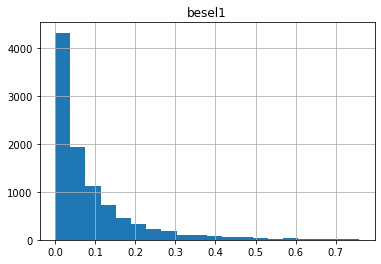

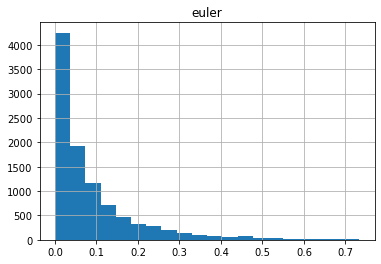

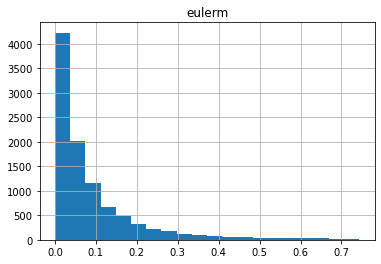

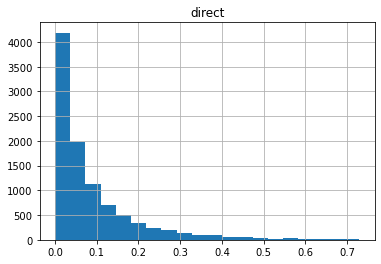

In [88]:
for name, F in zip(names, Fs):
    plt.figure()
    q = np.quantile(F, 0.99)
    plt.hist(F[F < q], bins=20)
    plt.grid()
    plt.title(name)
None